# FP

## v2 - softmax 2, pandas, 
## next v3 - GAN , embeddings and visualization:  tensorboard and ...matplot

Start writing all my logic in jupyter notebook in order to run them from anaconda! <br>
** IMPORTANT ** <br>
the network cell should only be intialize once! otherwise the program start creating indexes for the variables!!!! 

tensorboard --logdir=.\my_graph	
tensorboard => http://localhost:6006 <br>
jupyter => http://localhost:8889

## index: 
<a id='index'/>

1. READ DATA 
    * Class 
    * files 
2. [Network](#model)
3. [execution](#exec) 
4. [display](#disp)


other: 
4. [Evaluate](#ev) 
5. [Test](#ts) 
6. [Other](#o)

[go back](#index)

In [2]:
import pandas as pd 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

import requests
import json
import sys
import os
import time
from types import *
from collections import Counter
from datetime import datetime

In [2]:
import utils_data as md

start = time.time()
start

1515586859.9617217

In [3]:
datetime.now().strftime('%H:%M:%S')

'13:20:59'

In [4]:
# tensorboard --logdir=.\mygraph

In [5]:
print("hello")

hello


# Network  <a id="model"></a> 
[go back](#index)

In [6]:
def get_nns(): 
    #nns =  str(ninp)+'*'+str(h[0])+'*'+str(h[1])+'*'+str(nout)
    nns =  str(ninp)+'x' 
    for i in range(len(h)):
        nns = nns +str(h[i])+'x'
    return nns +str(nout)
#script hpar (s)
def get_hpar(ep=100, final="_"): return "slr_%.0E_NN%s_ep%s%s" % (lr, get_nns(),str(ep),final)
def logr(datep = '' , time='', it=1000, nn='', typ='TR', DS='', AC=0, num=0, AC3=0, AC10=0, desc='', startTime=''):
    if desc == '': print("Log not recorded"); return 
    LOG = "../../LOGT2.txt"
    f= open(LOG ,"a+") #w,a,
    if datep != '':   dats = datep
    else:             dats = datetime.now().strftime('%d.%m.%Y') 
    if time != '':    times = time
    else:             times = datetime.now().strftime('%H:%M:%S') 

    line =  datetime.now().strftime('%d.%m.%Y') + '\t' + times # time C1,C2
    #v1
    # line = line + '\t' + str(it) + '\t'+  get_nns() +  '\t' + str(lr) # IT NN LR TYP 
    #v2
    line = line + '\t' +  get_hpar(epochs, final=final) + '\t'+ '\t' 
    # values 
    line = line + '\t' + typ + '\t' + str(DS) # type + domain 
    line = line + '\t' + str(AC) + '\t' + str(num) + '\t' + str(AC3) + '\t' +  str(AC10) + '\t' + desc 
    line = line + '\t' + str(batch_size) + '\t' +  startTime + '\n' #new

    f.write(line);  f.close()
    print("___Log recorded")    

# NETWORK-----------------------------------------------------
def fc(inp, nodes, kp, is_train):
    # h = tf.layers.dense( x, h[0], activation=tf.nn.relu,  name )
    h = tf.layers.dense( inp, nodes, use_bias=False, activation=None )
    if md.dType != "C0": h = tf.layers.batch_normalization(h, training=is_train)      # CLASS
    h = tf.nn.relu(h)
    h = tf.nn.dropout(h, kp)
    return h
def build_network2(is_train=False):     # Simple NN - with batch normalization (high level)
    global top_k

    kp = 0.5
    inp = x
    # h0 = fc(x,  h[0], kp, is_train)
    # h1 = fc(h0, h[1], kp, is_train)    
    for i in range(len(h)): 
        hx = fc(inp,  h[i], kp, is_train); inp = hx 
    out = tf.layers.dense( hx, nout, use_bias=False, activation=None )
    prediction=tf.reduce_max(y,1)    # CLASS
    prediction = out                 # REG

    # softmaxT = tf.nn.softmax(out)
    with tf.name_scope("accuracy"):
        softmaxT = tf.nn.top_k(tf.nn.softmax(out), top_k)                       # CLASS
        correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))       # CLASS
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))      # CLASS

        if md.dType == "C0":
            total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))        # REG
            unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, out)))                # REG
            accuracy = tf.subtract(tf.to_float(1), tf.div(total_error, unexplained_error))   # REG

        tf.summary.scalar("accuracy", accuracy)

    return out, accuracy, softmaxT

def build_network3():
    tf.reset_default_graph()

    print("build network")
    global prediction, accuracy, softmaxT, cost, summ, optimizer, saver, x, y 
    x = tf.placeholder(tf.float32,   shape=[None, ninp], name="x")
    # y = tf.placeholder(tf.int16,     shape=[None, nout], name="y")
    y = tf.placeholder(tf.float32,     shape=[None, nout], name="y")
    prediction, accuracy, softmaxT = build_network2()
    
    with tf.name_scope("xent"): #loss
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
        if md.dType == "C0": cost = tf.reduce_mean(tf.square(prediction-y) )               # REG
        tf.summary.scalar("xent", cost)
    
    with tf.name_scope("train"): #optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    summ = tf.summary.merge_all()
    saver= tf.train.Saver()
    
def restore_model(sess):   
    saver= tf.train.Saver() 
    print("Model restored from file: %s" % model_path)
    saver.restore(sess, model_path)

# RNN

In [ ]:
#---------------------------------------------------------------------
def build_network3(is_train=False):     # RNN - embeddings
    global ninp, nout
    kp = 0.5; 
    
    # I cannot use embeddings because they only allow int32 and int64
    # but my data is in percentage - decimals ... - experiment 
    # embedding = tf.Variable(tf.random_uniform((ninp, h[0]), -1, 1))
    # h0 = tf.nn.embedding_lookup(embedding, x)
    # h0 = tf.gather(embedding, x)

    #only solution: 
    # - Train: 
    #index = dst[i].nonzero()
    #for j in index:
    #    wtemp.append(w0[j]) 
    #    xtmp.append(dst[i].iloc[j])
    #wtemp.dot(xtmp)  
    #run optimize feed_dict h0: h0, y: y ... 
    
    # h0 = tf.layers.dense( x, h[0], activation=tf.nn.relu,  name )
    # h0 = tf.layers.dense( x, h[0], use_bias=False, activation=None )
    # h0 = tf.layers.batch_normalization(h0, training=is_train)
    # h0 = tf.nn.relu(h0)
    # h0 = tf.nn.dropout(h0, kp)
    
    h1 = tf.layers.dense( h0, h[1], use_bias=False, activation=None )
    h1 = tf.layers.batch_normalization(h1, training=is_train)
    h1 = tf.nn.relu(h1)
    # h1 = tf.nn.dropout(h1, kp)
    
    out = tf.layers.dense( h1, nout, use_bias=False, activation=None )
    out = tf.layers.batch_normalization(out, training=is_train)
    out = tf.nn.relu(out)
    # out = tf.nn.dropout(h0, kp)
 
    # softmaxT = tf.nn.softmax(out)
    softmaxT = tf.nn.top_k(tf.nn.softmax(out), 4)
            
    prediction=tf.reduce_max(y,1)
    correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return out, accuracy, softmaxT 

# GAN

the goal is to recreate new data and identify possible fake values. 


In [17]:
#---------------------------------------------------------------------
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, h[0], use_bias=False, activation=None )
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #x1 = tf.nn.dropout(x1, kp)
        x2 = tf.layers.dense( x1, h[1], use_bias=False, activation=None )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        h1 = tf.nn.relu(x2)
        # h1 = tf.nn.dropout(x2, kp)
        out = tf.layers.dense( h1, nout, use_bias=False, activation=None )
        return out   
    
extra_class = 0        
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(x, h[0], use_bias=False, activation=None )
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #x1 = tf.nn.dropout(x1, kp)
        x2 = tf.layers.dense( x1, h[1], use_bias=False, activation=None )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        h1 = tf.nn.relu(x2)
        # h1 = tf.nn.dropout(x2, kp)
        class_logits  = tf.layers.dense( h1, nout+extra_class, use_bias=False, activation=None )
        # out = tf.layers.batch_normalization(out, training=is_train)
        # out = tf.nn.relu(out)
        # out = tf.nn.dropout(out, kp)

        if extra_class:
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        else:
            real_class_logits = class_logits
            fake_class_logits = 0.
            
        mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - mx
        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        out = tf.nn.softmax(class_logits)
        return out, class_logits, gan_logits, features
        
def model_loss(input_real, input_z, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.):
    g_size_mult = 32
    d_size_mult = 64
    
    g_model = generator(input_z, output_dim, alpha=alpha, size_mult=g_size_mult)
    d_on_data = discriminator(input_real, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_real, class_logits_on_data, gan_logits_on_data, data_features = d_on_data
    d_on_samples = discriminator(g_model, reuse=True, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_fake, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
    
    
    
    
    
    return d_loss, g_loss, correct, masked_correct, g_model

def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    for t in t_vars:
        assert t in d_vars or t in g_vars
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    shrink_lr = tf.assign(learning_rate, learning_rate * 0.9)
    return d_train_opt, g_train_opt, shrink_lr

class GAN:
    def __init__(self, real_size, z_size, learning_rate, num_classes=10, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        self.input_real, self.input_z, self.y, self.label_mask = model_inputs(real_size, z_size)
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")
        
        loss_results = model_loss(self.input_real, self.input_z,
                                    real_size[2], self.y, num_classes, label_mask=self.label_mask, alpha=0.2,
                                    drop_rate=self.drop_rate) 
        
        self.d_loss, self.g_loss, self.correct, self.masked_correct, self.samples = loss_results       
        
        self.d_opt, self.g_opt, self.shrink_lr = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        

print("net declared")

GAN built


In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0003

# # net = GAN(real_size, z_size, learning_rate)

# x = tf.placeholder(tf.float32,   shape=[None, ninp], name="x")
# z = tf.placeholder(tf.float32,   shape=[None, ninp], name="z")
# y = tf.placeholder(tf.int16,     shape=[None, nout], name="y")
# lm= tf.placeholder(tf.int32, (None), name='label_mask')
print("GAN built")

In [ ]:
#Train GAN ...
def trainGAN(net, dataset, epochs, batch_zize, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.normal(0,1, size=(50,z_size))

# OPERATIONS

In [7]:
# OPERATIONS-----------------------------------------------------
def train(it = 100, disp=50, batch_size = 128, compt = False): 
    print("____TRAINING...")
    display_step =  disp 

    dataTest = {'label' : [] , 'data' :  [] };
    if compt: 
        md.get_columns(pp_excel = True )  #md.dsc or dataset? 
        dataTest['data'] = md.dsc.iloc[:, 3:].as_matrix().tolist(); dataTest['label'] = md.dsc.iloc[:, 2].as_matrix().tolist()

        
    print("data read - lenTrain={}-{} & lenEv={}-{}" .format(len(md.dataT["data"]), len(md.dataT["label"]),len(md.dataE["data"]),len(md.dataE["label"]) ))
    total_batch  = int(len(md.dataT['label']) / batch_size)   
    startTime = datetime.now().strftime('%H:%M:%S')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # restore_model(sess)  #Run if I want to retrain an existing model  
        writer = tf.summary.FileWriter(md.MODEL_DIR + "tboard/", sess.graph ) # + get_hpar() )

        start = time.time()
        for i in range(it):            
            for ii, (xtb,ytb) in enumerate(md.get_batches(batch_size) ):
                # xtb, ytb = dc.next_batch(batch_size, dataT['data'], dataT['label'])
                sess.run(optimizer, feed_dict={x: xtb, y: ytb})
                if ii % display_step ==0: #record_step == 0:
                    #[train_accuracy] = sess.run([accuracy], feed_dict={x: xtb, y: ytb })
                    # s = sess.run(summ, feed_dict={x: xtb, y: ytb })
                    [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: xtb, y: ytb }) 
                    writer.add_summary(s, i)
                     
                    elapsed_time = float(time.time() - start)
                    reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
                    rp_s = str(reviews_per_second)[0:5]
                    tr_ac = str(train_accuracy)[:5]  
                    print('Epoch: {} batch: {} / {} - %Speed(it/disp_step): {} - tr_ac {}' .format(i, ii, total_batch, rp_s, tr_ac ))
                    # writer.add_summary(s, i)
            test_accuracy = sess.run( accuracy, feed_dict={ x: md.dst.iloc[:md.spn, 3:],  y: md.dst.loc[:md.spn-1,'FP_P'].as_matrix().tolist()  })
            ev_ac = str(test_accuracy)[:5]  
            print("E Ac:", ev_ac)
            
            if compt: 
                sess.run([optimizer], feed_dict={x: dataTest['data'], y: dataTest['label']})
                tr_ac = str(sess.run(accuracy, feed_dict={x: dataTest['data'], y: dataTest['label']}))[:5] 
                print("Cm Ac:", tr_ac)
            
            train_accuracy = sess.run( accuracy, feed_dict={ x: md.dst.iloc[md.spn:, 3:],  y: md.dst.loc[md.spn:,'FP_P'].as_matrix().tolist()   })
            tr_ac = str( train_accuracy )[:5] 
            print("T Ac:", tr_ac)

            train_accuracies.append(tr_ac)
            test_accuracies.append(ev_ac)

        save_path = saver.save(sess, model_path)
        print("Model saved in file: %s" % save_path) 
    print("Optimization Finished!")

    logr( it=it, typ='TR', DS=md.DESC, AC=tr_ac,num=len(md.dst)-md.spn, AC3=0, AC10=0, desc=md.des(), startTime=startTime )
    logr( it=it, typ='EV', DS=md.DESC, AC=ev_ac,num=md.spn, AC3=0, AC10=0, desc=md.des() )
    dataTest = {'label' : [] , 'data' :  [] };
    
def evaluate( ): 
    print("_____EVALUATION...")
    startTime = datetime.now().strftime('%H:%M:%S')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # test the model
        tr_ac = str(sess.run( accuracy, feed_dict={ x: md.dst.iloc[md.spn:, 3:],  y: md.dst.loc[md.spn:,'FP_P'].as_matrix().tolist()    }) )[:5]  
        ev_ac = str(sess.run( accuracy, feed_dict={ x: md.dst.iloc[:md.spn, 3:],  y: md.dst.loc[:md.spn-1,'FP_P'].as_matrix().tolist()  }))[:5] 
        print("Training   Accuracy:", tr_ac )
        print("Evaluation Accuracy:", ev_ac )
        # xtp1.append(dataTest['data'][i]);    ytp1.append(dataTest['label'][i])
        predv, softv = sess.run([prediction, softmaxT], feed_dict={x: md.dst.iloc[:md.spn, 3:]  }) # , y: md.dataE['label'] 
        # maxa = sess.run([prediction], feed_dict={y: predv })
        
    print("Preview the first predictions:")
    for i in range(20):
        print("RealVal: {}  - PP value: {}".format( md.dc( md.dst.loc[:md.spn-1,'FP_P'][i])   , 
                                                    md.dc( predv.tolist()[i], np.max(predv[i]))  ))
    gt3, gtM = md.check_perf_CN(softv, md.dst.loc[:md.spn-1,'FP_P'], False)
    logr(  it=epochs, typ='EV', AC=ev_ac,DS=md.DESC, num=md.spn, AC3=gt3, AC10=gtM, desc=md.des(), startTime=startTime )
    return predv.tolist()

def tests(url_test = 'url', p_col=False):  
    print("_____TESTS...")    
    
    # Load test data 
    dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
    if p_col:                   # test columns 
        md.get_columns( )  #md.dsc
        dataTest['data'] = md.dsc.iloc[:, 3:].as_matrix().tolist(); dataTest['label'] = md.dsc.iloc[:, 2].as_matrix().tolist()
    else: 
        if url_test != 'url':   # test  file 
            json_data = url_test + "data_jsonX.txt"
            tmpLab = pd.read_csv(url_test + "datalX.csv", sep=',', usecols=[0,1])    
            tmpLab = tmpLab.loc[:,'fp']
            DESC   = "FREXP1_X"
        else:                   # get data test JSON = url
            json_str, tmpLab = md.get_data_test(md.DESC)
            json_data = json.loads(json_str)
            DESC =  'matnrList...'
        force = False
        md.get_tests(url_test ) #dsp
        dataTest['data']  = md.dsp.iloc[:, 3:].as_matrix().tolist(); dataTest['label'] = md.dsp.iloc[:, 2].as_matrix().tolist()     
    # Predict data 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # predv = sess.run( prediction, feed_dict={x: dataTest['data']}) 
        ts_acn = '0'
        ts_acn, predv, sf = sess.run( [accuracy, prediction, softmaxT], feed_dict={x: dataTest['data'], y: dataTest['label']}) 
        ts_ac = str(ts_acn) 
        print("test ac = {}".format(ts_ac))
    # print(dataTest['label']);     print(sf)
    range_ts = len(predv) if len(predv)<20 else 20
    for i in range( range_ts ):
        # print("RealVal: {}  - PP value: {}".format( md.dc( dataTest['label'][i]), md.dc( predv.tolist()[i], np.max(predv[i]))  ))  
        print("{} RealVal: {} - {} - PP: {} PR: {}".format( i, md.dc( dataTest['label'][i]), sf[1][i][0],  sf[1][i], sf[0][i]   ))

    # return
    gt3, gtM = md.check_perf_CN(sf, dataTest["label"], False)
    logr( it=0, typ='TS', DS=DESC, AC=ts_acn ,num=len(dataTest["label"]),  AC3=gt3, AC10=gtM, desc=md.des() )  

    # outfile = md.LOGDAT + 'export2' 
    # np.savetxt(outfile + '.csv', sf[1], delimiter=',')
    # np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')
    dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
    return sf

def clean_traina():
    global train_accuracies, test_accuracies
    train_accuracies, test_accuracies = [], []
    
def vis_chart( ):
    fig, ax = plt.subplots()
    plt.plot(train_accuracies, label='Train', alpha=0.5)
    plt.plot(test_accuracies, label='Test', alpha=0.5)
    plt.title("Accuracy" + md.MODEL_DIR)
    plt.legend()
    plt.savefig(md.MODEL_DIR + "chart.png" )
    # plt.show()
    return

# Network1 - TES

In [10]:
md.DESC      = "FRFLO" # "FREXP"  FRFLO
md.spn       = 5000  
md.dType     = "C4" #C1, C2, C4, C0
epochs       = 10 #100

lr           = 0.001 #0.0001
h            = [100 , 40]   #[40 , 10]   [200, 100, 40] [100,100]
ninp, nout   = 10, 10
disp         = 5
batch_size   = 128
final        = "_" #FF or _


#---------------------------------------------------------------
# DATA READ 
#---------------------------------------------------------------
ALL_DS     = md.LOGDAT + md.DESC + md.DSC 
md.mainRead2(ALL_DS, 1, 2, all = True, shuffle = True  ) 
# md.mainRead2(ALL_DS, 1, 2, all = False ) # For testing I am forced to used JSON - column names and order may be different! 
md.normalize()
ninp, nout, top_k = md.getnn()
# print(len(md.dst))
md.MODEL_DIR = md.LOGDIR + md.DESC + '/'   + get_hpar(epochs, final=final) +"/" 
model_path = md.MODEL_DIR + "model.ckpt" 

data read - 9610 - time:5.139930248260498


In [11]:
force = True        
url_test = md.LOGDAT + "FREXP1/" ; # url_test = "url"
md.get_tests(url_test=url_test, force=force, pp_excel=True)
# md.get_columns(force, True)

In [12]:
build_network3()
print(model_path)
print( get_nns() )

md.MODEL_DIR

build network
../../dmodels/FRFLO/slr_1E-03_NN1814x100x40x4_ep10_/model.ckpt
1814x100x40x4


'../../dmodels/FRFLO/slr_1E-03_NN1814x100x40x4_ep10_/'

# EXECUTIONS <a id="exec"/>
[go back](#index)

In [25]:
def fprint(ds, ds_pred):
    
    pass

In [8]:
clean_traina()

In [13]:
train(epochs, disp, batch_size, True)

____TRAINING...
data read - lenTrain=0-0 & lenEv=0-0
4608
Epoch: 0 batch: 0 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.421
Epoch: 0 batch: 5 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.554
Epoch: 0 batch: 10 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.585
Epoch: 0 batch: 15 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.593
Epoch: 0 batch: 20 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.664
Epoch: 0 batch: 25 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.632
Epoch: 0 batch: 30 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.609
Epoch: 0 batch: 35 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.625
E Ac: 0.592
Cm Ac: 0.288
T Ac: 0.611
4608
Epoch: 1 batch: 0 / 0 - %Speed(it/disp_step): 0.471 - tr_ac 0.648
Epoch: 1 batch: 5 / 0 - %Speed(it/disp_step): 0.445 - tr_ac 0.585
Epoch: 1 batch: 10 / 0 - %Speed(it/disp_step): 0.422 - tr_ac 0.640
Epoch: 1 batch: 15 / 0 - %Speed(it/disp_step): 0.403 - tr_ac 0.585
Epoch: 1 batch: 20 / 0 - %Speed(it/disp_step): 0.383 - tr_ac 0.625
Epoch: 1 batch: 25 / 0 - %Speed(it/disp_step): 0.

In [20]:
evd = evaluate( )


_____EVALUATION...
Model restored from file: ../../dmodels/FRFLO/slr_1E-03_NN1814x100x40x4_ep10_/model.ckpt
INFO:tensorflow:Restoring parameters from ../../dmodels/FRFLO/slr_1E-03_NN1814x100x40x4_ep10_/model.ckpt
Training   Accuracy: 0.742
Evaluation Accuracy: 0.722
Preview the first predictions:
RealVal: 3  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
denormalization all Evaluation : 5000 = 5000
0
1000
2000
3000
4000
Total: 5000 GT3: 1401  GTM: 1401
___Log recorded


[[-4.022150993347168,
  -2.6135215759277344,
  3.3134877681732178,
  1.410142421722412],
 [-2.2124228477478027,
  -0.09963478147983551,
  2.536189556121826,
  -0.8594834804534912],
 [-5.695163726806641,
  -1.931778907775879,
  2.3757102489471436,
  1.3581881523132324],
 [-7.464658737182617,
  -1.3955912590026855,
  5.284692287445068,
  -4.200284481048584],
 [-3.316721200942993,
  -0.9321587681770325,
  1.805626392364502,
  0.3309983015060425],
 [-5.548260688781738,
  -1.7882126569747925,
  4.136926174163818,
  1.299536108970642],
 [-5.289621829986572,
  -2.0793488025665283,
  1.044637680053711,
  0.6135182976722717],
 [-5.720174312591553,
  -2.682352304458618,
  1.0389251708984375,
  1.443446397781372],
 [-3.0230636596679688, -1.95361328125, 1.8881702423095703, 0.9919428825378418],
 [-6.22544527053833,
  -1.4617713689804077,
  2.792989730834961,
  -0.6535383462905884],
 [-6.485321521759033,
  -2.8951523303985596,
  0.02001744508743286,
  0.997407853603363],
 [-7.792513847351074,
  -3.0

In [25]:
# fprint(ran, data, pred)

# Ex Test

In [17]:
# md.dsp
sft = tests(url_test, p_col=False  )
# vis_chart( )

_____TESTS...
Model restored from file: ../../dmodels/FRFLO/slr_1E-03_NN1814x100x40x4_ep10_/model.ckpt
INFO:tensorflow:Restoring parameters from ../../dmodels/FRFLO/slr_1E-03_NN1814x100x40x4_ep10_/model.ckpt
test ac = 0.782526
0 RealVal: 2 - 2 - PP: [2 1 3] PR: [ 0.86945075  0.07472938  0.04678858]
1 RealVal: 2 - 2 - PP: [2 1 3] PR: [ 0.97834468  0.01164451  0.00970478]
2 RealVal: 2 - 2 - PP: [2 3 1] PR: [ 0.97545779  0.02158127  0.00290852]
3 RealVal: 2 - 2 - PP: [2 3 1] PR: [ 0.71837658  0.24715932  0.03316817]
4 RealVal: 3 - 2 - PP: [2 3 1] PR: [ 0.50464571  0.48525044  0.00843631]
5 RealVal: 2 - 2 - PP: [2 3 1] PR: [ 0.96643829  0.02740041  0.00612573]
6 RealVal: 2 - 2 - PP: [2 1 3] PR: [ 0.99625045  0.00265258  0.00107913]
7 RealVal: 3 - 3 - PP: [3 2 1] PR: [  8.91452968e-01   1.07804157e-01   5.90244133e-04]
8 RealVal: 2 - 2 - PP: [2 3 1] PR: [ 0.7773627   0.21117058  0.01111807]
9 RealVal: 2 - 2 - PP: [2 3 1] PR: [ 0.70445532  0.29320312  0.00232437]
10 RealVal: 2 - 3 - PP: [3 2

In [16]:
# print(dataTest['data'])
sft

TopKV2(values=array([[ 0.99492669,  0.00284422,  0.00222413],
       [ 0.93628854,  0.05829639,  0.0053506 ],
       [ 0.90507323,  0.06112721,  0.03216427],
       ..., 
       [ 0.98532027,  0.01292858,  0.00173244],
       [ 0.50647753,  0.48536527,  0.00720088],
       [ 0.9072634 ,  0.08589637,  0.00495737]], dtype=float32), indices=array([[2, 3, 1],
       [2, 3, 1],
       [2, 1, 3],
       ..., 
       [2, 1, 3],
       [2, 3, 1],
       [3, 2, 1]]))

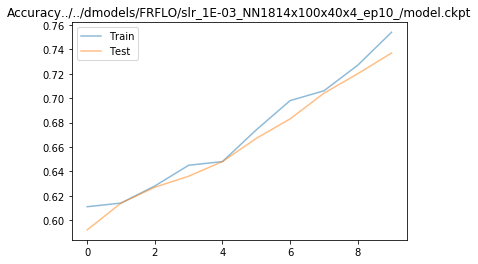

In [15]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy"+model_path)
plt.legend()
plt.show()
plt.savefig(md.MODEL_DIR + "chart.png" )


# 1RUN 

In [36]:
import mRun as mr
execc = [
            { 'dt':'C2',  "e":100, "lr":0.001, "h":[100 , 100], "spn": 5000, "pe": [], "pt": []  },
            { 'dt':'C4',  "e":100, "lr":0.001, "h":[100 , 100], "spn": 5000, "pe": [], "pt": []  },
            { 'dt':'C1',  "e":100, "lr":0.001, "h":[100 , 100], "spn": 5000, "pe": [], "pt": []  },
        ]

final = "_" ;  md.DESC = "FRAFLO";  # FRFLO   FRALL1
ALL_DS = md.LOGDAT + md.DESC + md.DSC 

In [ ]:
# DATA READ 
# md.mainRead2(ALL_DS, 1, 2 ) # , all = True, shuffle = True  ) 
md.mainRead2(path=ALL_DS, part=1, batch_size=2 ) # For testing I am forced to used JSON - column names and order may be different! 
url_test = md.LOGDAT + "FREXP1/" ; # url_test = "url"
force = False; excel = True  # dataFile = "frall2_json.txt"; labelFile = "datal.csv"     
md.get_tests(url_test, force, excel )

In [ ]:
for ex in execc:
    md.spn = ex["spn"]; md.dType = ex["dt"]; mr.epochs = ex["e"]

    md.normalize()
    mr.ninp, mr.nout, mr.top_k = md.getnn()
    md.MODEL_DIR = md.LOGDIR + md.DESC + '/'   + mr.get_hpar(mr.epochs, final=final) +"/" 
    mr.model_path = md.MODEL_DIR + "model.ckpt" 
    mr.build_network3()
    print(mr.model_path)    

    # mr.evaluate( )

    ex["pt"] = mr.tests(url_test, p_col=False  )

In [ ]:
print("0<60_1>60__0<23_1<60_2<93_3>93  ")
for i in range(20):
    print("m:{0:15} - R-{4:5}   ||    P1-{1:2}         P2-{2:2}        P3-{3}" 
    .format(md.dsp.iloc[i,0], execc[0]["pt"][1][i][0], execc[1]["pt"][1][i][0],  execc[2]["pt"][1][i], md.dsp.iloc[i,1], ))    


# Embedding by FAM
get data / get FAM <br>
if am > 0 => 1; lookup tab.  => visualization embeddings in script. 


In [66]:
#logic... 




# WRITE EXCEL

In [27]:
# import xlsxwriter
# outfile = '../../_zfp/data/export.xlsx' 

# workbook   = xlsxwriter.Workbook(outfile)
# worksheet1 = workbook.add_worksheet()
# worksheet1.write('A1', 'M')
# worksheet1.write(0, 0, 'Hello')  
# for i in range(len(sf[0])):
#     worksheet1.write(0, i , sf[0][i])  
#     worksheet1.write(1, i , sf[1][i]) 

In [28]:
# import csv
# outfile = '../../_zfp/data/export.csv' 
# f2= open(outfile,"a+")
# output_writer = csv.writer(f2, delimiter="\t")
# output_writer.writerows(sf)
# f2.close()

In [29]:
# outfile = '../../_zfp/data/export2' 
# np.savetxt(outfile + '.csv', sf[1], delimiter=',')
# np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')

# Display visualizations <a id="disp"/>
[go back](#index)

In [30]:
# path = outfile = '../../_zfp/data/FRFLO/datasc.csv' 
# dst  =  pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python")
Y  = dst.loc[:,'FP'].as_matrix().tolist()
X  = dst.loc[:, 'M'].as_matrix().tolist()

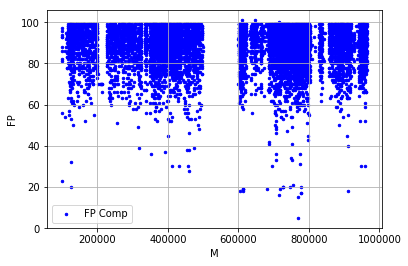

In [31]:
# 2 - Create plot. 
a = 1
if a == 0: 
    plt.hist(Y)
else: 
    plt.xlabel('M')
    plt.ylabel('FP')
    plt.grid(True)
    N = 2 #50
    colors = np.random.rand(N)
    area = 1 #np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

    #plt.plot(X, Y, color='blue', marker='o', label='FP Comp')
    #plt.plot(X, Y, 'bo', label='FP Comp')
    plt.scatter(X,Y, s=6, c='b', marker='o', cmap=None, norm=None, vmin=60, vmax=101, alpha=None,  label='FP Comp')
    # plt.plot(X, Y,  s=area, c=colors, alpha=0.5) #'bo', label='FP Comp',
    plt.legend()

# 3 - Display plot. 

plt.show()